In [33]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt

In [34]:
# Orbital parameters provided
a_sin_i = 115.531  # Semi-major axis in light-seconds
P_orb = 27.6943 * 86400  # Orbital period in seconds
e = 0.1029  # Eccentricity
omega = np.deg2rad(-74.05)  # Longitude of periastron in radians
T_pi2 = 58116.097  # T_pi/2 in seconds 

In [ ]:
# Step 1: Function to extract MET and header info from FITS file
def extract_fits_info(fits_file):
    with fits.open(fits_file) as hdul:
        header = hdul[1].header  # Assuming the event data is in the 1st extension
        mjdrefi = header['MJDREFI']
        mjdreff = header['MJDREFF']
        leap_seconds = header.get('LEAPINIT', 0)  # Default to 0 if LEAPINT not present
        met = hdul[1].data['TIME']  # Assuming MET is stored in the 'TIME' column
    return met, mjdrefi, mjdreff, leap_seconds

# Step 2: Convert MET to Modified Julian Date (MJD)
def convert_met_to_mjd(met, mjdrefi, mjdreff, leap_seconds):
    # MET is in seconds, convert it to days
    met_in_days = met / 86400.0
    # Compute MJD
    mjd = met_in_days + mjdrefi + mjdreff + (leap_seconds / 86400.0)
    return mjd

# Step 2.5: Convert the reference from initial time of kepler orbit.
# def convert_mjd_from_t_pi2(mjd):
#     elapsed_time= (mjd-T_pi2)*86400
#     #elapsed_time= (mjd)
#     return elapsed_time

# Step 3: Calculate Mean Anomaly M
def calculate_mean_anomaly(mjd, T_pi2, P_orb):
    return 2 * np.pi * ((mjd - T_pi2)) / P_orb +  np.pi/2

# Step 4: Compute Eccentric Anomaly E using Mikkola's cubic approximation variable s
def compute_eccentric_anomaly_proxy(mean_anomaly, e):
    alpha = (1 - e) / (4 * e + 0.5)
    beta = 0.5 * mean_anomaly / (4 * e + 0.5)

    # Compute z based on the condition on beta sign
    z = np.where(
        beta >= 0,
        np.cbrt((beta + np.sqrt(beta**2 + alpha**3))),
        np.cbrt((beta - np.sqrt(beta**2 + alpha**3)))
    )

    print(z)

    s = z - alpha/z
    return s

# Step 5: Incorporate error term as done in Mikkola 1987
def correct_eccentric_anomaly(mean_anomaly,s, e):
    ds = (-0.078 * s**5) / (1 + e)
    s_true=s+ds
    eccentric_anomaly = mean_anomaly + e * (3 * s_true - 4 * s_true**3)
    return eccentric_anomaly

# Step 6: Calculate Rømer time delay for the binary system
def calculate_romer_delay(eccentric_anomaly, e, a_sin_i,omega):
    sin_E = np.sin(eccentric_anomaly)
    cos_E = np.cos(eccentric_anomaly)
    return (a_sin_i * ( (cos_E-e)*np.sin(omega)+
                       np.sqrt(1-e**2) * sin_E * np.cos(omega))
                       )

# Step 7: Correct Event Timestamp
def correct_event_timestamp(met, romer_delay):
    return met - romer_delay

# Full process combining orbital correction
def correct_nicer_timestamps(fits_file):
    # Extract information from FITS file
    met, mjdrefi, mjdreff, leap_seconds = extract_fits_info(fits_file)
    # Convert MET to MJD
    mjd = convert_met_to_mjd(met, mjdrefi, mjdreff, leap_seconds)
    # Calculate from Kepler reference
    # elapsed_time=convert_mjd_from_t_pi2(mjd)
    # Calculate Mean Anomaly
    mean_anomaly = calculate_mean_anomaly(mjd, T_pi2, P_orb)
    
    # Compute Eccentric Anomaly
    s = compute_eccentric_anomaly_proxy(mean_anomaly, e)
    
    # Correct Eccentric Anomaly
    corrected_eccentric_anomaly = correct_eccentric_anomaly(mean_anomaly,s, e)
    
    # Calculate Rømer delay
    romer_delay = calculate_romer_delay(corrected_eccentric_anomaly, e, a_sin_i,omega)
    
    # Correct Event Timestamps
    corrected_timestamps = correct_event_timestamp(met, romer_delay)

    ###Debugging
    print(f'MET: {met}')
    print(f"Mean Anomaly: {mean_anomaly}")
    print(f"Eccentric Anomaly Proxy: {s}")
    print(f"Corrected Eccentric Anomaly: {corrected_eccentric_anomaly}")
    print(f"Rømer Delay: {romer_delay}")
    print(f'corrected timestamps: {corrected_timestamps}')

    
    return met,mjd,corrected_timestamps

In [27]:
# Example usage:
fits_file = './6050390244/xti/event_cl/ni6050390244_0mpu7_cl_night.evt'

met,_,corrected_times = correct_nicer_timestamps(fits_file)

[1.29433985 1.29433985 1.29433985 ... 1.29434009 1.29434009 1.29434009]
MET: [3.00001414e+08 3.00001414e+08 3.00001414e+08 ... 3.00046339e+08
 3.00046339e+08 3.00046339e+08]
Mean Anomaly: [1.57608523 1.57608523 1.57608523 ... 1.5760866  1.5760866  1.5760866 ]
Eccentric Anomaly Proxy: [0.53403419 0.53403419 0.53403419 ... 0.53403459 0.53403459 0.53403459]
Corrected Eccentric Anomaly: [1.67838114 1.67838114 1.67838114 ... 1.67838249 1.67838249 1.67838249]
Rømer Delay: [54.75492686 54.75492686 54.75492686 ... 54.75507141 54.75507141
 54.75507141]
corrected timestamps: [3.00001359e+08 3.00001359e+08 3.00001359e+08 ... 3.00046284e+08
 3.00046284e+08 3.00046284e+08]


In [ ]:
def write_corrected_fits(original_fits, corrected_timestamps):
    # Extract the 10-digit identifier from the filename
    base_name = os.path.basename(original_fits)
    identifier = base_name.split('_')[0]  # Assuming the identifier is the first part of the filename

    # Construct the output directory
    output_dir = f'{identifier}/xti/event_cl/'

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Modify the 'TIME' column with corrected timestamps
    with fits.open(original_fits, mode='readonly') as hdul:
        hdul[1].data['TIME'] = corrected_timestamps
        
        # Construct the new filename
        new_file = os.path.join(output_dir, base_name.replace('.evt', '_corrected.evt'))
        
        # Write the new FITS file
        hdul.writeto(new_file, overwrite=True)
    
    print(f"Corrected FITS file saved as {new_file}")


#write_corrected_fits(fits_file,corrected_times)

In [28]:
hdu=fits.open(fits_file)
hdu[1].data['TIME']+hdu[1].header['MJDREFI']+hdu[1].header['MJDREFF']+hdu[1].header['LEAPINIT']

array([3.00058074e+08, 3.00058074e+08, 3.00058074e+08, ...,
       3.00102999e+08, 3.00102999e+08, 3.00102999e+08])

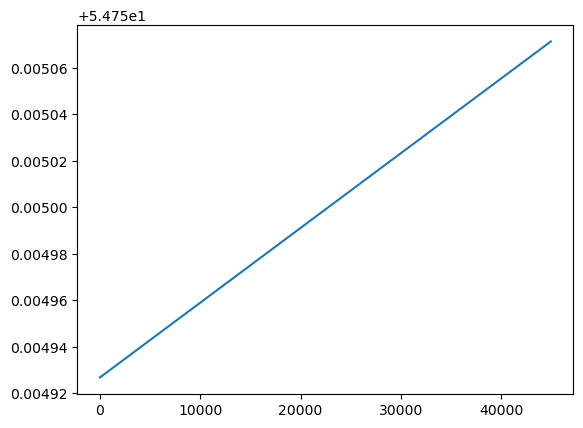

In [32]:
plt.plot(met-met.min(),met-corrected_times)
# plt.plot(arrival_times)
#plt.plot(met-corrected_times)